In [8]:
import os
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from scipy.ndimage import zoom

# Add the path to the parent directory of 'plot.py'
sys.path.append(os.path.abspath('../'))
from plot import *

## Load the dataset and save it in memory

In [3]:
# !! Skip this cell if you have already loaded the data !!
# Function to load data from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'rb') as f:
            image, label = pickle.load(f)
            # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
            image = np.transpose(image, (1, 2, 0))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Paths to your data directories
train_dir = "../../data/classification_dataset/train"
validation_dir = "../../data/classification_dataset/validation"
test_dir = "../../data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)

# Save the datasets
np.savez("train_dataset.npz", images=train_images, labels=train_labels)
np.savez("validation_dataset.npz", images=val_images, labels=val_labels)
np.savez("test_dataset.npz", images=test_images, labels=test_labels)

In [43]:
# Load the pre-saved data
train_data = np.load("train_dataset.npz")
train_images, train_labels = train_data["images"], train_data["labels"]

val_data = np.load("validation_dataset.npz")
val_images, val_labels = val_data["images"], val_data["labels"]

test_data = np.load("test_dataset.npz")
test_images, test_labels = test_data["images"], test_data["labels"]

# Convert data to tf.data.Dataset
def create_tf_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

train_dataset = create_tf_dataset(train_images, train_labels)
validation_dataset = create_tf_dataset(val_images, val_labels)
test_dataset = create_tf_dataset(test_images, test_labels)

# Batch and shuffle the datasets
BATCH_SIZE = 32
SEED = 42

train_dataset = train_dataset.shuffle(buffer_size=1000,seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
num_classes = 2

In [44]:
print(len(train_images), len(val_images), len(test_images))

53535 7436 13386


# 1. Study the performance of the classifier with all the 12 spectral bands

## Training of a basic model without adjusted class weights or data augmentation

In [26]:
model = Sequential([
  layers.Conv2D(16, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
epochs=10
history_no_classweights = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)
# no_classweights_10_ephocs

Epoch 1/10


2025-01-02 20:43:11.725490: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1673/1673 [==============================] - 523s 312ms/step - loss: 0.2754 - accuracy: 0.8626 - val_loss: 0.5720 - val_accuracy: 0.6561
Epoch 2/10
1673/1673 [==============================] - 1394s 834ms/step - loss: 0.2131 - accuracy: 0.8969 - val_loss: 0.4282 - val_accuracy: 0.7797
Epoch 3/10
1673/1673 [==============================] - 2649s 2s/step - loss: 0.1945 - accuracy: 0.9049 - val_loss: 0.3618 - val_accuracy: 0.8330
Epoch 4/10
1673/1673 [==============================] - 122s 73ms/step - loss: 0.1945 - accuracy: 0.9055 - val_loss: 0.4386 - val_accuracy: 0.7667
Epoch 5/10
1673/1673 [==============================] - 4309s 3s/step - loss: 0.1870 - accuracy: 0.9090 - val_loss: 0.3180 - val_accuracy: 0.8760
Epoch 6/10
1673/1673 [==============================] - 125s 75ms/step - loss: 0.1800 - accuracy: 0.9138 - val_loss: 0.3820 - val_accuracy: 0.8206
Epoch 7/10
1673/1673 [==============================] - 126s 75ms/step - loss: 0.1776 - accuracy: 0.9150 - val_loss: 0.4583 - va

In [29]:
# Save the model
tf.keras.models.save_model(model, 'no_classweights_10_epochs.keras', overwrite=True)

In [30]:
#plotting confusion matrix
model_no_classweights = tf.keras.models.load_model('no_classweights_10_epochs.keras')

## Results of a basic model without adjusted class weights or data augmentation

233/233 [==============================] - 5s 18ms/step


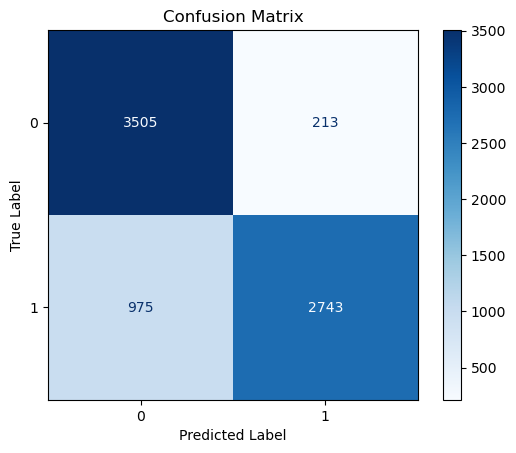

In [31]:
confusion_matrix_plot(model_no_classweights,validation_dataset)

In [32]:
f1_baseline = calculate_f1_score(model,validation_dataset)
print('F1-score baseline:',f1_baseline)

233/233 [==============================] - 4s 19ms/step
F1-score baseline: 0.8219958046149236


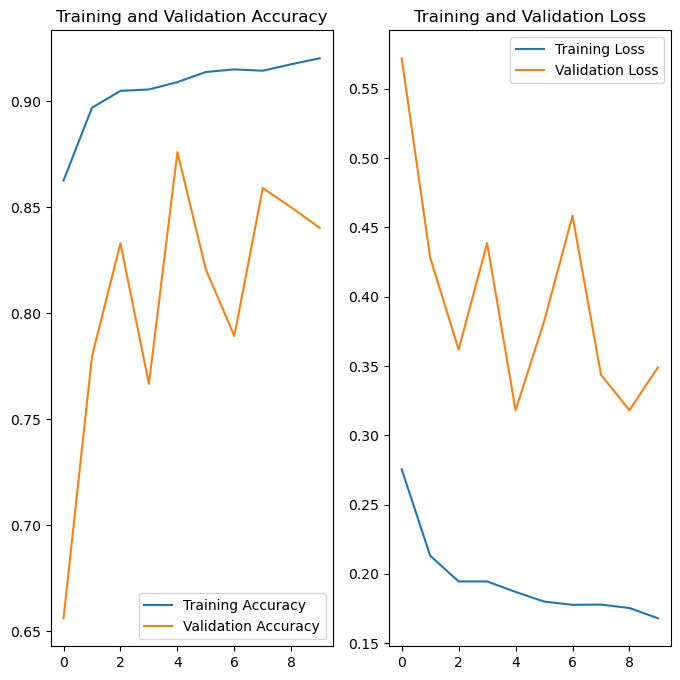

In [33]:
plot_results(history_no_classweights, epochs)

## Training of a model with class weights

In [6]:
def calculate_class_weights(dataset):
    # Extract all labels from the dataset
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(labels.numpy())

    # Count the occurrences of each class
    label_counts = Counter(all_labels)

    # Total number of samples
    total_samples = sum(label_counts.values())

    # Calculate weights for each class
    class_weights = {label: total_samples / (len(label_counts) * count) 
                     for label, count in label_counts.items()}

    return class_weights

# Calculate class weights for the train_dataset
class_weights = calculate_class_weights(train_dataset)
print("Class Weights:", class_weights)

Class Weights: {0: 0.5864792620670012, 1: 3.390866480871548}


In [35]:
epochs=10
history_classweights = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  class_weight = class_weights
)

Epoch 1/10
1673/1673 [==============================] - 126s 75ms/step - loss: 0.2528 - accuracy: 0.8580 - val_loss: 0.2330 - val_accuracy: 0.9075
Epoch 2/10
1673/1673 [==============================] - 126s 75ms/step - loss: 0.2297 - accuracy: 0.8763 - val_loss: 0.2358 - val_accuracy: 0.9038
Epoch 3/10
1673/1673 [==============================] - 5243s 3s/step - loss: 0.2313 - accuracy: 0.8693 - val_loss: 0.2422 - val_accuracy: 0.8969
Epoch 4/10
1673/1673 [==============================] - 24819s 15s/step - loss: 0.2194 - accuracy: 0.8794 - val_loss: 0.2646 - val_accuracy: 0.8790
Epoch 5/10
1673/1673 [==============================] - 9779s 6s/step - loss: 0.2193 - accuracy: 0.8785 - val_loss: 0.2369 - val_accuracy: 0.9076
Epoch 6/10
1673/1673 [==============================] - 125s 74ms/step - loss: 0.2150 - accuracy: 0.8834 - val_loss: 0.2294 - val_accuracy: 0.9090
Epoch 7/10
1673/1673 [==============================] - 124s 74ms/step - loss: 0.2149 - accuracy: 0.8819 - val_loss: 0.

In [36]:
model.save('with_classweights_10_epochs.keras')
model_classweights = tf.keras.models.load_model('with_classweights_10_epochs.keras')

## Results of a model with class weights

233/233 [==============================] - 4s 19ms/step


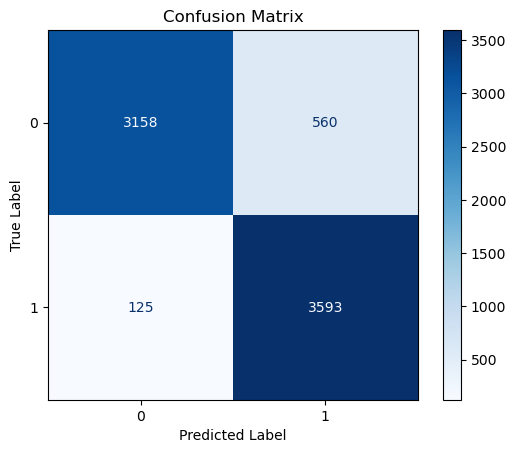

In [37]:
confusion_matrix_plot(model_classweights,validation_dataset)

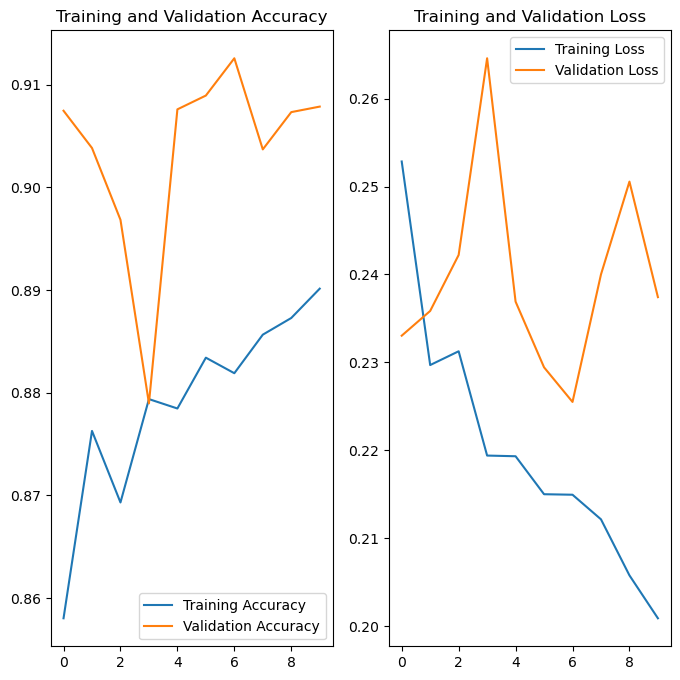

In [38]:
plot_results(history_classweights,epochs)

In [64]:
f1_weighted = calculate_f1_score(model_classweights,validation_dataset)
print('F1-score model with class weights:',f1_weighted)

233/233 [==============================] - 4s 17ms/step
F1-score model with class weights: 0.9129716681489011


## Training a model with class weights and data augmentation

In [7]:
def calculate_class_weights(dataset):
    # Extract all labels from the dataset
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(labels.numpy())

    # Count the occurrences of each class
    label_counts = Counter(all_labels)

    # Total number of samples
    total_samples = sum(label_counts.values())

    # Calculate weights for each class
    class_weights = {label: total_samples / (len(label_counts) * count) 
                     for label, count in label_counts.items()}

    return class_weights

# Calculate class weights for the train_dataset
class_weights = calculate_class_weights(train_dataset)
print("Class Weights:", class_weights)

Class Weights: {0: 0.5864792620670012, 1: 3.390866480871548}


In [15]:
model_augment = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.1),
  layers.Conv2D(16, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model_augment.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history_classweights_augment = model_augment.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=15,
  class_weight = class_weights
)

Epoch 1/15
 558/1673 [=========>....................] - ETA: 2:38 - loss: 0.4585 - accuracy: 0.6921

KeyboardInterrupt: 

In [9]:
model_augment.save('../../models/tensorflow_models/augment_with_classweights_15_epochs.keras')


NameError: name 'model_augment' is not defined

In [14]:
model_augment_classweights = tf.keras.models.load_model('../../models/tensorflow_models/augment_with_classweights_15_epochs.keras')

OSError: SavedModel file does not exist at: ../../models/tensorflow_models/augment_with_classweights_15_epochs.keras/{saved_model.pbtxt|saved_model.pb}

## Results of a model with class weights and data augmentation

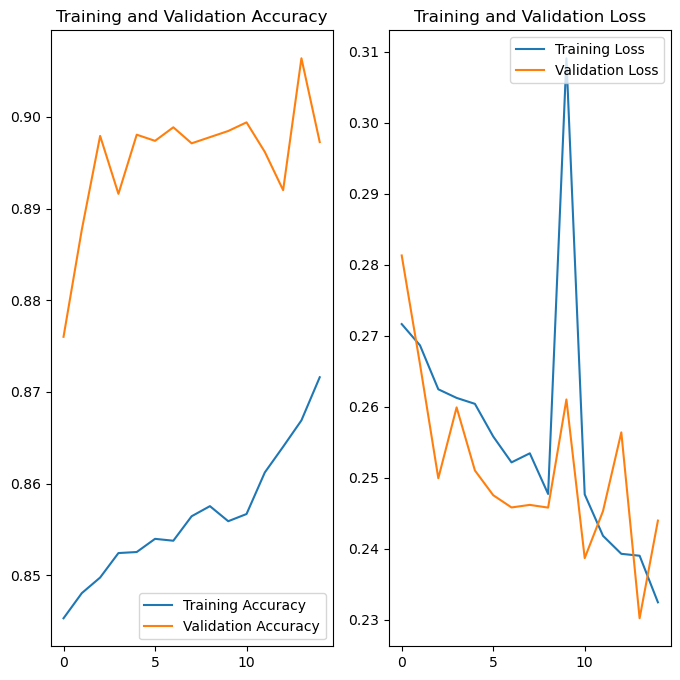

In [68]:
plot_results(history_classweights_augment,15)

233/233 [==============================] - 4s 17ms/step


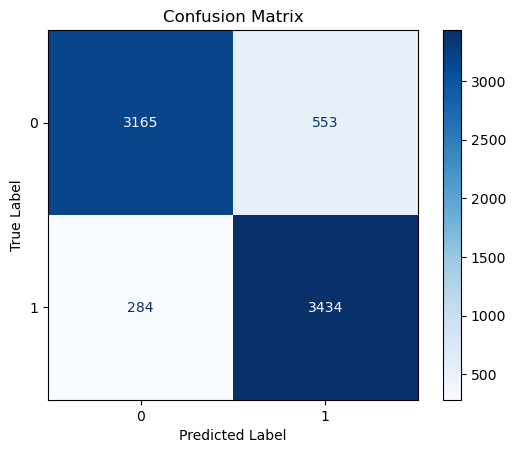

In [69]:
confusion_matrix_plot(model_augment_classweights,validation_dataset)

In [70]:
f1_augmented = calculate_f1_score(model_augment_classweights,validation_dataset)
print('F1-score model with class weights and augmented data:',f1_augmented)

233/233 [==============================] - 4s 17ms/step
F1-score model with class weights and augmented data: 0.8913692407527579


## PCA

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# Flatten the images to 1D vectors (32x32 images)
X_train_flattened = train_images.reshape(train_images.shape[0], -1)
X_val_flattened = val_images.reshape(val_images.shape[0], -1)
X_test_flattened = test_images.reshape(test_images.shape[0], -1)

In [46]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_val_scaled = scaler.transform(X_val_flattened)
X_test_scaled = scaler.transform(X_test_flattened)


In [47]:
# Perform PCA
pca = PCA(n_components=12)  # or use n_components_95 for 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [48]:
# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
# Determine number of components needed for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {n_components_95}")

Number of components for 95% variance: 1


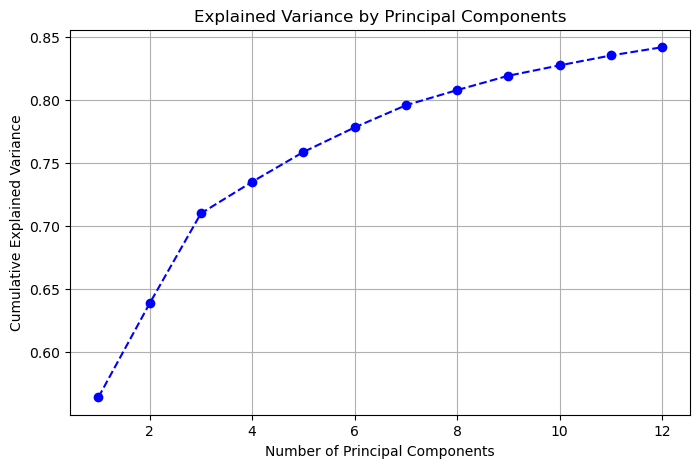

In [49]:
# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()


In [50]:
train_dataset_pca = create_tf_dataset(X_train_pca, train_labels)
validation_dataset_pca = create_tf_dataset(X_val_pca, val_labels)
test_dataset_pca = create_tf_dataset(X_test_pca, test_labels)

# Batch and shuffle the datasets
train_dataset_pca = train_dataset_pca.shuffle(buffer_size=1000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset_pca = validation_dataset_pca.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_pca = test_dataset_pca.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [52]:
train_images_pca = pca.transform(X_train_flattened)
val_images_pca = pca.transform(X_val_flattened)

print(train_images_pca.shape)  # Should output something like (num_samples, 12)


(53535, 12)


In [53]:
# Define model using PCA-reduced data
model_pca = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(12,)),  # Adjusted input shape for PCA data
    layers.Dense(128, activation='relu'),
    layers.Dense(2)  # Output layer (binary classification)
])

model_pca.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


In [60]:
# Train the model
history_classweights_pca = model_pca.fit(
    train_dataset_pca,  # PCA-reduced training data
    validation_data=validation_dataset_pca,  # PCA-reduced validation data
    epochs=20,
    class_weight=class_weights  # Pass the class weights here
)

# Save the trained model
model_pca.save('../../models/tensorflow_models/pca_with_classweights_15_epochs.keras')


Epoch 1/20
1673/1673 [==============================] - 1s 653us/step - loss: 0.3206 - accuracy: 0.8118 - val_loss: 0.3386 - val_accuracy: 0.8503
Epoch 2/20
1673/1673 [==============================] - 1s 691us/step - loss: 0.3189 - accuracy: 0.8133 - val_loss: 0.3351 - val_accuracy: 0.8609
Epoch 3/20
1673/1673 [==============================] - 1s 719us/step - loss: 0.3167 - accuracy: 0.8155 - val_loss: 0.3275 - val_accuracy: 0.8662
Epoch 4/20
1673/1673 [==============================] - 1s 676us/step - loss: 0.3144 - accuracy: 0.8186 - val_loss: 0.3281 - val_accuracy: 0.8584
Epoch 5/20
1673/1673 [==============================] - 1s 700us/step - loss: 0.3119 - accuracy: 0.8196 - val_loss: 0.3201 - val_accuracy: 0.8753
Epoch 6/20
1673/1673 [==============================] - 1s 709us/step - loss: 0.3104 - accuracy: 0.8226 - val_loss: 0.3319 - val_accuracy: 0.8642
Epoch 7/20
1673/1673 [==============================] - 1s 706us/step - loss: 0.3094 - accuracy: 0.8230 - val_loss: 0.3182 -

In [61]:
model_pca = tf.keras.models.load_model('../../models/tensorflow_models/pca_with_classweights_15_epochs.keras')

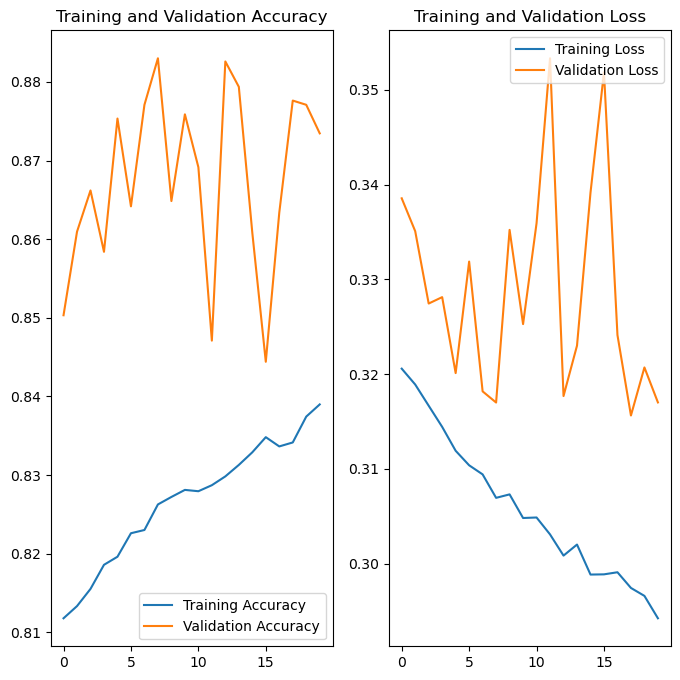

In [62]:
plot_results(history_classweights_pca,20)

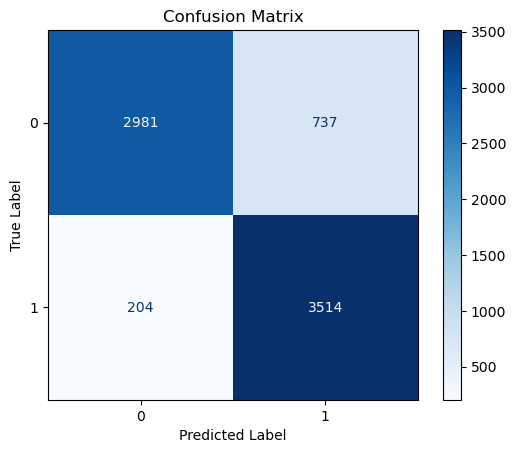

In [63]:
confusion_matrix_plot(model_pca,validation_dataset_pca)

In [65]:
f1_augmented_pca = calculate_f1_score(model_pca,validation_dataset_pca)
print('F1-score model with class weights and augmented data:',f1_augmented_pca)

F1-score model with class weights and augmented data: 0.8819174300414104


The reduction in performance after applying PCA, as shown by a decrease in the F1 score and worse results in the confusion matrix, suggests that the transformation might have discarded some important information during dimensionality reduction. 

# 2. Study the performance of the classifier with RGB and NIR bands

## Training a model with class weights and data augmentation

In [46]:
def filter_rgb_nir(images):
    return images[:, :, :, [3, 2, 1, 7]]  # Bands: Red (4), Green (3), Blue (2), NIR (8)

# Filter datasets
train_images_rgb_nir = filter_rgb_nir(train_images)
val_images_rgb_nir = filter_rgb_nir(val_images)
test_images_rgb_nir = filter_rgb_nir(test_images)

# Define the model for RGB + NIR bands
model_rgb_nir = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    layers.Conv2D(16, 12, padding='same', activation='relu', input_shape=(32, 32, 4)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)  # Binary classification
])

# Compile the model
model_rgb_nir.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [47]:
# Convert the filtered data to TensorFlow datasets
train_dataset_rgb_nir = tf.data.Dataset.from_tensor_slices((train_images_rgb_nir, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_rgb_nir = tf.data.Dataset.from_tensor_slices((val_images_rgb_nir, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history_rgb_nir = model_rgb_nir.fit(
    train_dataset_rgb_nir,
    validation_data=validation_dataset_rgb_nir,
    epochs=10,
    class_weight=class_weights
)

# Save the model
model_rgb_nir.save('model_rgb_nir.keras')

Epoch 1/10
1673/1673 [==============================] - 94s 55ms/step - loss: 0.4069 - accuracy: 0.7070 - val_loss: 0.3692 - val_accuracy: 0.8384
Epoch 2/10
1673/1673 [==============================] - 791s 473ms/step - loss: 0.3713 - accuracy: 0.7317 - val_loss: 0.3474 - val_accuracy: 0.8351
Epoch 3/10
1673/1673 [==============================] - 92s 55ms/step - loss: 0.3314 - accuracy: 0.7611 - val_loss: 0.3353 - val_accuracy: 0.8254
Epoch 4/10
1673/1673 [==============================] - 95s 57ms/step - loss: 0.3104 - accuracy: 0.8099 - val_loss: 0.3032 - val_accuracy: 0.8600
Epoch 5/10
1673/1673 [==============================] - 98s 59ms/step - loss: 0.2954 - accuracy: 0.8359 - val_loss: 0.2753 - val_accuracy: 0.8880
Epoch 6/10
1673/1673 [==============================] - 102s 61ms/step - loss: 0.2879 - accuracy: 0.8467 - val_loss: 0.2765 - val_accuracy: 0.8813
Epoch 7/10
1673/1673 [==============================] - 104s 62ms/step - loss: 0.2879 - accuracy: 0.8479 - val_loss: 0.27

In [48]:
tf.keras.models.save_model(
    model_rgb_nir, 'model_rgb_nir_10_epochs.keras', overwrite=True)

## Result of a model with class weights and data augmentation

233/233 [==============================] - 3s 15ms/step


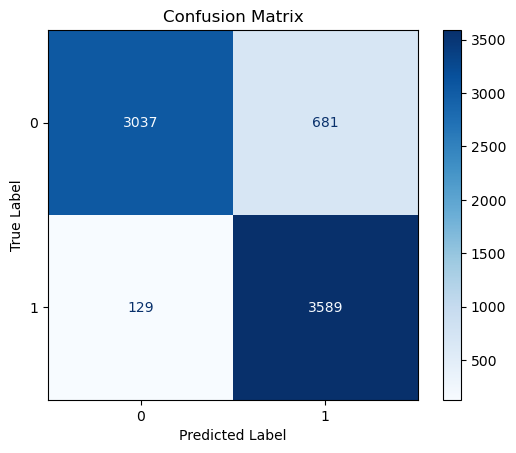

In [49]:
# True labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset_rgb_nir], axis=0)  
y_pred = np.argmax(model_rgb_nir.predict(validation_dataset_rgb_nir), axis=1)       

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize plot (optional)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Study the performance of the classifier with RGB bands only

## Training of a model with class weights and data augmentation

In [128]:
# Filter only RGB bands
def filter_rgb(images):
    return images[:, :, :, [3, 2, 1]]  # Bands: Red (4), Green (3), Blue (2)

# Filter datasets
train_images_rgb = filter_rgb(train_images)
val_images_rgb = filter_rgb(val_images)
test_images_rgb = filter_rgb(test_images)

In [51]:
# Define the model for RGB bands
model_rgb = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    layers.Conv2D(16, 12, padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 12, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)  # Binary classification
])

# Compile the model
model_rgb.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Convert the filtered data to TensorFlow datasets
train_dataset_rgb = tf.data.Dataset.from_tensor_slices((train_images_rgb, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_rgb = tf.data.Dataset.from_tensor_slices((val_images_rgb, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history_rgb = model_rgb.fit(
    train_dataset_rgb,
    validation_data=validation_dataset_rgb,
    epochs=10,
    class_weight=class_weights
)

# Save the model
model_rgb.save('model_rgb.keras')

Epoch 1/10
1673/1673 [==============================] - 97s 57ms/step - loss: 0.4178 - accuracy: 0.7013 - val_loss: 0.3936 - val_accuracy: 0.8190
Epoch 2/10
1673/1673 [==============================] - 106s 63ms/step - loss: 0.3841 - accuracy: 0.7166 - val_loss: 0.3721 - val_accuracy: 0.8232
Epoch 3/10
1673/1673 [==============================] - 107s 64ms/step - loss: 0.3564 - accuracy: 0.7475 - val_loss: 0.3258 - val_accuracy: 0.8378
Epoch 4/10
1673/1673 [==============================] - 108s 64ms/step - loss: 0.3279 - accuracy: 0.7883 - val_loss: 0.3120 - val_accuracy: 0.8545
Epoch 5/10
1673/1673 [==============================] - 107s 64ms/step - loss: 0.3096 - accuracy: 0.8156 - val_loss: 0.2981 - val_accuracy: 0.8748
Epoch 6/10
1673/1673 [==============================] - 116s 69ms/step - loss: 0.2975 - accuracy: 0.8255 - val_loss: 0.2935 - val_accuracy: 0.8725
Epoch 7/10
1673/1673 [==============================] - 116s 69ms/step - loss: 0.2876 - accuracy: 0.8313 - val_loss: 0.

In [52]:
tf.keras.models.save_model(
    model_rgb, 'model_rgb_10_epochs.keras', overwrite=True)

## Result of a model with class weights and data augmentation

233/233 [==============================] - 4s 17ms/step


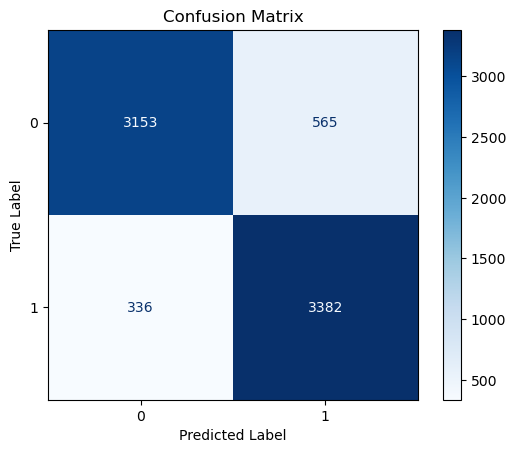

In [53]:
# True labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset_rgb], axis=0)  
y_pred = np.argmax(model_rgb.predict(validation_dataset_rgb), axis=1)       

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize plot (optional)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Sailiancy methods


Methods to analyze if sailiancy map says something??

The model parameter randomization test compares the output of a saliency method on a trained
model with the output of the saliency method on a randomly initialized untrained network of the
same architecture. If the saliency method depends on the learned parameters of the model, we should
expect its output to differ substantially between the two cases

The data randomization test compares a given saliency method applied to a model trained on a
labeled data set with the method applied to the same model architecture but trained on a copy of the
data set in which we randomly permuted all labels.

If a saliency method depends on the labeling of the data, we should again expect its outputs to differ significantly in the two cases. 

An insensitivity to the permuted labels, however, reveals that the method does not depend on the relationship between instances (e.g. images) and labels that exists in the original data


In [96]:
import cv2

In [192]:
model_rgb.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_2 (RandomRo  (None, 32, 32, 3)        0         
 tation)                                                         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        6928      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 32)        73760     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)        

In [198]:
index = 7
image_test = val_images_rgb[index]
print(val_labels[index])
LAYER_NAME = 'max_pooling2d_14'
CAT_CLASS_INDEX = 0

0


In [204]:
#Code:
#https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54

grad_model = tf.keras.models.Model([model_rgb.inputs], [model_rgb.get_layer(LAYER_NAME).output, model_rgb.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([image_test]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (32, 32))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

In [205]:
rgb_image = (image_test / np.max(image_test) * 255).astype(np.uint8)

In [206]:
print(rgb_image.shape)
print(cam.shape)

(32, 32, 3)
(32, 32, 3)


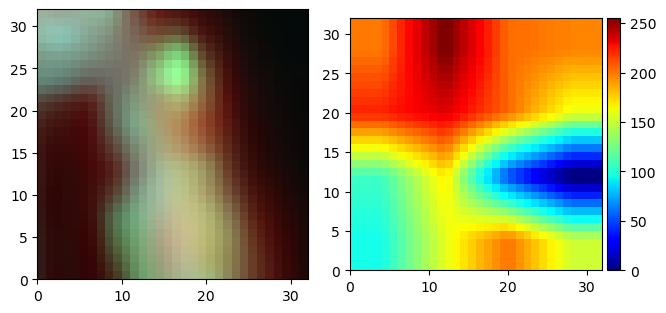

In [210]:
plt.subplot(1,2,1)
plt.pcolormesh(rgb_image)
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
plt.pcolormesh(cam, cmap='jet')
plt.gca().set_aspect('equal')

plt.tight_layout()

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(cax=cax)